In [6]:
import pandas as pd
from gensim import matutils, models
import scipy.sparse
import matplotlib.pyplot as plt
import logging
import re
import os
import numpy as np
#from gensim.models.ldamulticore import LdaMulticore
### choose the callbacks classes to import
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric

In [3]:
#reading necessary inputs for lda from pickle
import pickle as pkl

with open('pickled_1907/data_lemmatized.pkl', 'rb') as f:
    data_lemmatized = pkl.load(f)

with open('pickled_1907/cleaned_corpus.pkl', 'rb') as f:
    corpus = pkl.load(f)
with open("pickled_1907/id2word.pkl", 'rb') as f:
    id2word= pkl.load(f)


C:\Users\minha\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
logging.basicConfig(filename=f'pickled_1907/log_2507/lda_2019_new.log',
                        format="%(asctime)s:%(levelname)s:%(message)s",
                       level=logging.NOTSET)

In [ ]:
# Set up the callbacks loggers
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
convergence_logger = ConvergenceMetric(logger='shell')
coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = data_lemmatized)

In [4]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
# List of the different iterations to try
#iterations = [10, 40, 70, 100]
num_topics= np.array(list(range(2,31,1)))
num_ntopics = len(num_topics)
np.save("pickled_1907/try_ntopics",num_topics)
# The number of passes to use - could change depending on requirements
passes = 50
iteration=100
# init storage
perplexity = {}
coherence = {}


for i,topics in enumerate(num_topics):
   
    # Add text to logger to indicate new model
    logging.debug(f'Start of model: {topics} topics')

    # Create model - note callbacks argument uses list of created callback loggers
    model = LdaMulticore(corpus=corpus,
             id2word=id2word,
             num_topics=topics,
#            eval_every=20,
            chunksize=300,
             passes=passes,
             iterations=iteration,
            random_state=100,
            per_word_topics=True)
            #callbacks=[convergence_logger, perplexity_logger, coherence_cv_logger])
   
        #Compute Perplexity
    perplexity[topics] = model.log_perplexity(corpus)  # a measure of how good the model is. lower the better.

        # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence[topics] = coherence_model_lda.get_coherence()
        #save results
    model.save(f"pickled_1907/trained_models/trained_lda_model_{topics}.model")
    with open("pickled_1907/trained_models/perplexity.pkl", 'wb') as f:
        pkl.dump(perplexity, f)
    with open("pickled_1907/trained_models/coherence.pkl", 'wb') as f:
        pkl.dump(coherence, f) 

    # Add text to logger to indicate end of this model
    logging.debug(f'End of model: {topics} topics')
    # screen report
    print(f"Num Topics = {topics}: Perplexity = {perplexity[topics]}, Coherence = {coherence[topics]}")


Num Topics = 2: Perplexity = -7.616401714110531, Coherence = 0.35274577748924596
Num Topics = 3: Perplexity = -7.579699275368264, Coherence = 0.35315088971773534
Num Topics = 4: Perplexity = -7.54248456873646, Coherence = 0.37529942942827477
Num Topics = 5: Perplexity = -7.52625612581445, Coherence = 0.4011690682002338
Num Topics = 6: Perplexity = -7.502092540715527, Coherence = 0.4341842105878802
Num Topics = 7: Perplexity = -7.531732563713009, Coherence = 0.4414529663576118
Num Topics = 8: Perplexity = -7.597059955847644, Coherence = 0.4398919800526968
Num Topics = 9: Perplexity = -7.686435196994767, Coherence = 0.44728430362352434
Num Topics = 10: Perplexity = -7.793690634340589, Coherence = 0.4497830523286613
Num Topics = 11: Perplexity = -7.901681396311028, Coherence = 0.4641107443381774
Num Topics = 12: Perplexity = -8.001438630992958, Coherence = 0.480406872785087
Num Topics = 13: Perplexity = -8.07666578934296, Coherence = 0.44823888781886395
Num Topics = 14: Perplexity = -8.14

In [4]:
with open("pickled_1907/trained_models/perplexity.pkl", 'rb') as f:
    perplexity = pkl.load(f)
with open("pickled_1907/trained_models/coherence.pkl", 'rb') as f:
    coherence= pkl.load(f) 

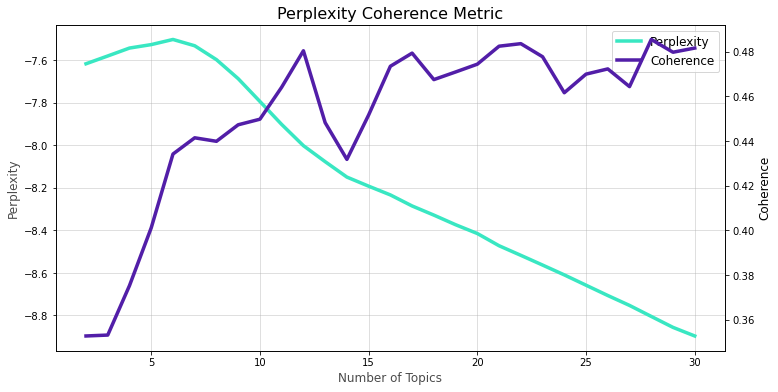

In [8]:
# Plot coherence and perplexity scores

# grab colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# init figure
fig, ax = plt.subplots(figsize=(12,6))

# plot perplexity
lists = sorted(perplexity.items())
x, y = zip(*lists) 
pltp = ax.plot(x, y, label='perplexity', linewidth=3.5,color="#39e7c2") 
# plot coherence
ax2 = ax.twinx() 
lists = sorted(coherence.items())
x, y = zip(*lists) 
pltc = ax2.plot(x, y, label='coherence', linewidth=3.5, color = "#521ea8")


# axis labels
ax.set_xlabel('Number of Topics', fontsize=12,alpha=0.7)
ax.set_ylabel('Perplexity', fontsize=12,alpha=0.7)
ax2.set_ylabel('Coherence', fontsize=12)
ax.set_title('Perplexity Coherence Metric', fontsize=16)
ax.xaxis.set_tick_params(grid_alpha=0.5)
ax.yaxis.set_tick_params(grid_alpha=0.5)
# legend
ax.legend(pltp+pltc, ['Perplexity', 'Coherence'], fontsize=12, loc='best')

# aesthetics
ax.grid()
plt.savefig("C:/Users/minha/Desktop/plots/perplexity.jpg",dpi=300)